In [35]:
import subprocess
import shlex
import pandas as pd
import numpy as np
from astropy.table import Table
from astropy.table import Column
import os
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.ticker import MultipleLocator
import glob
from matplotlib import pyplot
import matplotlib.gridspec as gridspec
import gc

In [4]:
basedir = "/home/xhall/Documents/"

RedshiftClass = Table.from_pandas(pd.read_csv(basedir + "NewZTF/ML_sample_snid200.csv"))
ML_sample_snid_examples = Table.from_pandas(pd.read_csv(basedir + "NewZTF/ML_sample_snid_brightexamples.csv"))
sample_2018 = Table.from_pandas(pd.read_csv(basedir + "NewZTF/sample_2018/ML_sample_snid_2018.csv"))

In [5]:
source = basedir + "NewZTF/sample_2018/SNIDoutput/"
output = basedir + "NewZTF/sample_2018/ImageOutput/"

In [6]:
def read_tables(files):
    matches_files = files[0:len(files)-1]
    spectra = Table.read(files[-1], format = "ascii", names = ["wavelength", "flux"])
    matches = []
    for i in matches_files:
        input_data = open(i,'r').readlines()[0].split()
        row = [[int(input_data[3][0]), input_data[4],input_data[5][1::],float(input_data[-3].split("-")[-1]),float(input_data[-1])]]
        row.append(Table.read(i, format = "ascii", names = ["redshifted_wavelength", "flux"]))
        matches.append(row)
    return matches, spectra

In [7]:
def plot_box_spec(wave, flux): 
    flux_plot = np.repeat(flux, 2)
    wv_plot = wave.copy()
    wv_plot[:-1] += np.diff(wave)/2
    wv_plot = np.append(wave[0]-(wave[1]-wave[0])/2, 
                        np.append(np.repeat(wv_plot[0:-1], 2), 
                                  wave[-1]+(wave[-1]-wave[-2])/2))
    
    return wv_plot, flux_plot

In [70]:
def specplot(x,y,xi,yi,snid_type,fname,output,best_num, z_template, z_template_unc, z_snid):
    fig = plt.figure(figsize=(8,5))
    gs = fig.add_gridspec(1, 2, width_ratios=[10, 1], wspace=0.05)
    ax = fig.add_subplot(gs[0])
    ax1 = fig.add_subplot(gs[1])
    ax1.set_yticklabels([])
    ax1.set_xticklabels([])
    
    ax1.boxplot([-2 * z_template_unc, 2 * z_template_unc])
    ax1.hlines(z_snid-z_template,.75,1.25, color = "Blue")
    ax1.set_xticks([])
    ax1.set_yticks([])
    
    ax.plot(xi,yi,color='#32384D',alpha=0.5,
             label='New SN')
    ax.plot(x,y,color='#217CA3',
             label='SNID template', lw=3)
    #ax.plot(x[-3],y[-3],color='white',lw=0,
    #         label=r'$z_\mathrm{} = $ {:.3f}$\,\pm\,${:.3f}'.format("{SNID}", z_template, z_template_unc))
    ax.plot(x[-3],y[-3],color='#217CA3', lw=3)
    ax.set_xlabel(r'Rest Frame Wavelength ($\mathrm{\AA}$)', fontsize=17)
    ax.set_ylabel('Relative Flux', fontsize=17)
    ax.tick_params(which='both',labelsize=15)
    
    ax.grid(axis='x', color='0.7', ls=':')
    ax.xaxis.set_minor_locator(MultipleLocator(250))
    ax.set_yticklabels([])

    
    ax.text(0.105, 0.955, 'SNID type: ', 
            va='center',
            fontsize=15, transform=plt.gcf().transFigure)
    ax.text(0.245, 0.955, snid_type, 
            color='#217CA3', weight='bold', va='center',
            fontsize=23, transform=plt.gcf().transFigure)

    #ax.text(0.78, 0.955, r'$z_\mathrm{} = ${:.4f}'.format("{SN}", z_snid), 
    #        va='center',
    #        fontsize=15, transform=plt.gcf().transFigure)
    
    ax.legend(fancybox=True)
    
    fig.tight_layout()
    fig.subplots_adjust(left=0.055,right=0.965,top=0.925,bottom=0.145)
    fig.savefig(output + 'snidfits_emclip_' + fname + "_" + str(best_num) + '.png', dpi = 600)
    plt.show()
    plt.close(fig)
    plt.clf()

In [71]:
def plot_best_5(source, output, spectra_name, z_snid):
    source_folder = source + spectra_name
    
    files = np.sort(glob.glob(source_folder+"/*.dat"))
    if(len(files)==0):
        print(spectra_name)
        return -1
    matches, spectra = read_tables(files)
    
    for i in matches:
        z = i[0][3]
        snid_type = i[0][2][:-1]
        
        xi, yi = plot_box_spec(spectra["wavelength"], spectra["flux"])
        xi /= (1+z)
        x, y = i[1]["redshifted_wavelength"] / (1+z), i[1]["flux"]
        specplot(x,y,xi,yi,snid_type,spectra_name,output,i[0][0], z, i[0][4], z_snid)

In [66]:
sample_2018[0]

Version,ZTF_Name,sntemplate,c_rlap,c_snid,z_rlap,z_snid,z_snid_err,age,age_flag,z_level,TNS_Name,discovered_by,tns_internal_name,RA_sn,Dec_sn,sn_type,z_sn,g_jd_max,g_max,g_unc_max,r_jd_max,r_max,r_unc_max,ebv,host_name_PS1,RA_host_PS1,Dec_host_PS1,z_host,sep,projected_kpc,gKron_PS1,rKron_PS1,iKron_PS1,zKron_PS1,yKron_PS1,w1_host,w2_host,ebv_host,Class,col3,col4,col5,col6,col7,col9
str39,str12,str11,float64,str7,float64,float64,float64,float64,int64,int64,str9,str13,str29,float64,float64,str9,float64,float64,float64,float64,float64,float64,float64,float64,str21,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str9,float64,float64,float64,float64,float64,int64
ZTF18aabssth_20180309_P60_v1.ascii,ZTF18aabssth,sn2011dh,7.86,IIb,7.86,0.0358,0.0075,-15.6,0,1,SN2018aex,ZTF,ZTF18aabssth,165.1891017637735,22.28749704183977,II,0.026,2458494.0531481,20.44230842590332,0.1942138969898224,2458218.7148727,18.741601943969727,0.0452471598982811,0.015359999999999999,PSO J165.1878+22.2877,165.18778907,22.28771869,0.022914,4.444857426598462,2.0566548608097266,16.885400772094727,16.492399215698242,16.382200241088867,16.378400802612305,16.610000610351562,15.79401524178536,16.38349243564084,0.015369999999999997,II,0.026000000000000002,0.022914,2458186.5,2458218.66,-32.16,1


/home/xhall/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


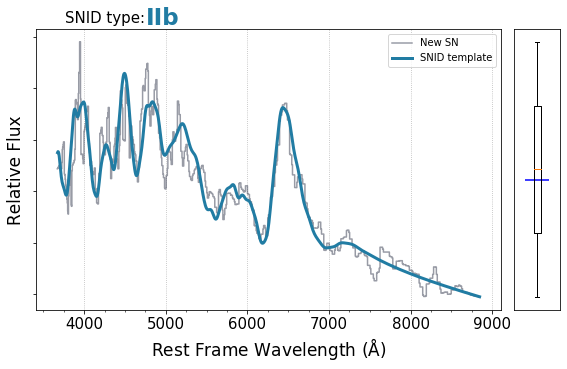

/home/xhall/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


<Figure size 432x288 with 0 Axes>

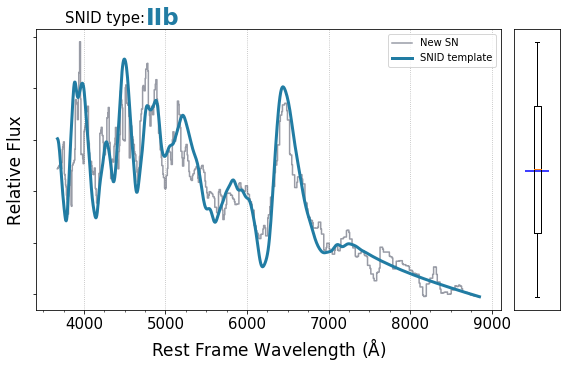

/home/xhall/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


<Figure size 432x288 with 0 Axes>

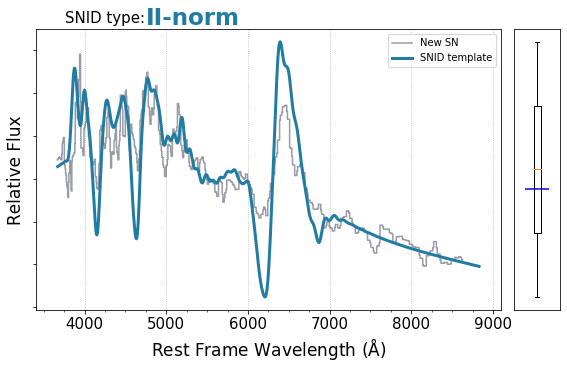

/home/xhall/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


<Figure size 432x288 with 0 Axes>

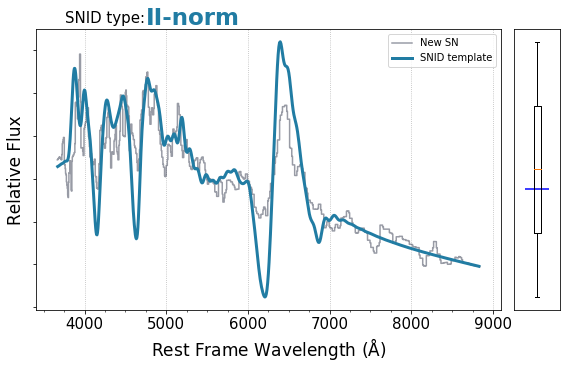

/home/xhall/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


<Figure size 432x288 with 0 Axes>

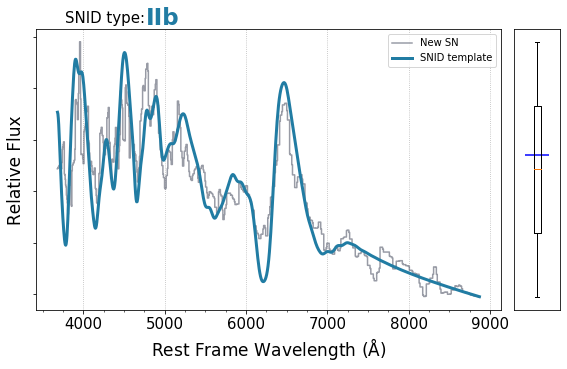

0


<Figure size 432x288 with 0 Axes>

In [72]:
counter = 0
for i in sample_2018:
    spectra_name = i["Version"].split(".")[0]
    z_snid = i["z_snid"]
    plot_best_5(source,output,spectra_name,z_snid)
    gc.collect()
    if(counter%20 == 0):
        print(counter)
    counter += 1
    break

In [13]:
pngs = glob.glob(output + "/*.png")

In [15]:
len(pngs)

7710

In [17]:
len(sample_2018)*5

7715

In [25]:
glob.glob(source + "/ZTF18aaxdrjn_20180531_P60_v1/*.*")

['/home/xhall/Documents/NewZTF/sample_2018/SNIDoutput//ZTF18aaxdrjn_20180531_P60_v1/snid.param',
 '/home/xhall/Documents/NewZTF/sample_2018/SNIDoutput//ZTF18aaxdrjn_20180531_P60_v1/ZTF18aaxdrjn_20180531_P60_v1_snid.output']

In [23]:
read_tables(np.sort(glob.glob(source + "/ZTF18aaxdrjn_20180531_P60_v1/*.dat")))

IndexError: index -1 is out of bounds for axis 0 with size 0

In [27]:
glob.glob(source + "/ZTF18aabssth_20180309_P60_v1/*.dat")

[]

In [12]:
plot_best_5("/home/xhall/Documents/RandomSNID/","/home/xhall/Documents/RandomSNID/","lris20201012_ZTF20acdehpz",0.1751)

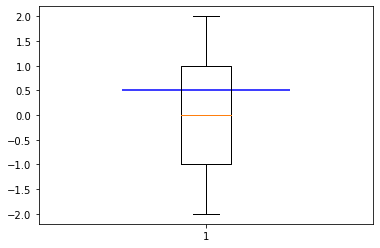

In [30]:
plt.boxplot([2 * -1, 2 * 1])
plt.hlines(.5,.75,1.25, color = "Blue")